In [1]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
from typing import Optional, Tuple
import math
import torch.utils.data as data
import torchvision
from matplotlib import pyplot as plt
import torch
from datetime import datetime
from tqdm.notebook import tqdm_notebook


Setting some parameters

In [2]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

Downloading MNIST from torchvision


In [3]:

# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='data/MNIST', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='data/MNIST', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

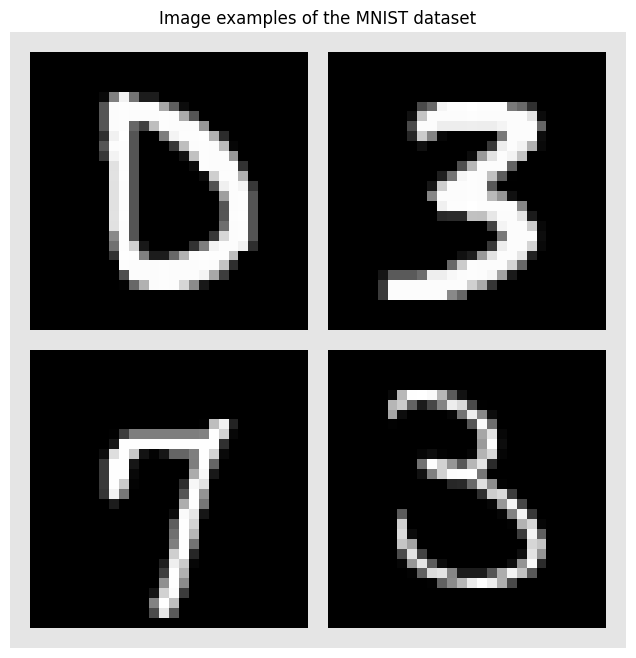

In [4]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


Visualizing img_to_patch function

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = jnp.transpose(x, (0, 2, 4, 1, 3, 5))  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.reshape(B, -1, C, patch_size, patch_size)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

In [6]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

TypeError: transpose requires ndarray or scalar arguments, got <class 'torch.Tensor'> at position 0.

VisionTransformer with LayerNorm

In [7]:
class AttentionBlockWithLayerNorm(nnx.Module):
    def __init__(self, rngs, embed_dim: int, hidden_dim: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        # Fix type annotations and ensure embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"

        self.layer_norm_1 = nnx.LayerNorm(embed_dim, rngs=rngs)
        # Fix the MultiHeadAttention instantiation
        self.attn = nnx.MultiHeadAttention(in_features=embed_dim, num_heads=num_heads, decode=False,rngs=rngs)
        self.layer_norm_2 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.linear = nnx.Sequential(
                nnx.Linear(embed_dim, hidden_dim, rngs=rngs),
                nnx.gelu,
                nnx.Dropout(dropout, rngs=rngs),
                nnx.Linear(hidden_dim, embed_dim, rngs=rngs),
                nnx.Dropout(dropout, rngs=rngs),
        )

    def __call__(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [8]:
class VisionTransformerWithLayerNorm(nnx.Module):

    def __init__(self, rngs:nnx.Rngs, embed_dim: int, hidden_dim: int, num_heads: int,
                 num_layers: int, patch_size: int, num_channels: int,
                 num_patches: int, num_classes: int, dropout: float=0.0):
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nnx.Linear(num_channels * (patch_size**2), embed_dim, rngs=rngs)
        self.transformer = nnx.Sequential(
                *(AttentionBlockWithLayerNorm(rngs=rngs, embed_dim=embed_dim,
                                              hidden_dim=hidden_dim,
                                              num_heads=num_heads,
                                              dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nnx.Sequential(nnx.LayerNorm(embed_dim, rngs=rngs),
                                       nnx.Linear(embed_dim, num_classes, rngs=rngs))
        self.dropout = nnx.Dropout(dropout, rngs=rngs)

        # Parameters/Embeddings
        self.cls_token = nnx.Param(jax.random.normal(rngs.params(), (1, 1, embed_dim), dtype=jnp.float32))
        self.pos_embedding = nnx.Param(jax.random.normal(rngs.params(), (1, num_patches + 1, embed_dim), dtype=jnp.float32))

    def __call__(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = jnp.tile(self.cls_token, (B, 1, 1))
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transformer
        x = self.dropout(x)
        x = jnp.transpose(x, (1, 0, 2))

        # Pass the decode parameter to transformer
        # This assumes transformer will propagate decode to each AttentionBlock
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

VisionTransformer
with DyT


In [9]:
# Dynamic Tanh implementation
class DyT(nnx.Module):
    def __init__(self, num_features :jnp.int8, alpha_init_value : jnp.float32 =0.5):
        self.alpha = nnx.Param(
                jnp.ones((1,)) * alpha_init_value,
                name="alpha",
        )
        self.weight = nnx.Param(
                jnp.ones((num_features,)),
                name="weight",
        )
        self.bias = nnx.Param(
                jnp.zeros((num_features,)),
                name="bias",
        )

    def __call__(self, x):
        x = jnp.tanh(self.alpha * x)
        return x * self.weight + self.bias


In [10]:
class AttentionBlockWithDyT(nnx.Module):
    def __init__(self, rngs, embed_dim: int, hidden_dim: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        # Fix type annotations and ensure embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"

        self.dyt_1 = DyT(embed_dim)
        # Fix the MultiHeadAttention instantiation
        self.attn = nnx.MultiHeadAttention(in_features=embed_dim, num_heads=num_heads, decode=False,rngs=rngs)
        self.dyt_2 = DyT(embed_dim)
        self.linear = nnx.Sequential(
                nnx.Linear(embed_dim, hidden_dim, rngs=rngs),
                nnx.gelu,
                nnx.Dropout(dropout, rngs=rngs),
                nnx.Linear(hidden_dim, embed_dim, rngs=rngs),
                nnx.Dropout(dropout, rngs=rngs),
        )

    def __call__(self, x):
        inp_x = self.dyt_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.dyt_2(x))
        return x

In [11]:
class VisionTransformerWithDyT(nnx.Module):

    def __init__(self, rngs:nnx.Rngs, embed_dim: int, hidden_dim: int, num_heads: int,
                 num_layers: int, patch_size: int, num_channels: int,
                 num_patches: int, num_classes: int, dropout: float=0.0):
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nnx.Linear(num_channels * (patch_size**2), embed_dim, rngs=rngs)
        self.transformer = nnx.Sequential(
                *(AttentionBlockWithDyT(rngs=rngs, embed_dim=embed_dim,
                                              hidden_dim=hidden_dim,
                                              num_heads=num_heads,
                                              dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nnx.Sequential(nnx.LayerNorm(embed_dim, rngs=rngs),
                                       nnx.Linear(embed_dim, num_classes, rngs=rngs))
        self.dropout = nnx.Dropout(dropout, rngs=rngs)

        # Parameters/Embeddings
        self.cls_token = nnx.Param(jax.random.normal(rngs.params(), (1, 1, embed_dim), dtype=jnp.float32))
        self.pos_embedding = nnx.Param(jax.random.normal(rngs.params(), (1, num_patches + 1, embed_dim), dtype=jnp.float32))

    def __call__(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = jnp.tile(self.cls_token, (B, 1, 1))
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transformer
        x = self.dropout(x)
        x = jnp.transpose(x, (1, 0, 2))

        # Pass the decode parameter to transformer
        # This assumes transformer will propagate decode to each AttentionBlock
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

Initializing the model

In [13]:
model_with_layer_norm = VisionTransformerWithLayerNorm(
    rngs=nnx.Rngs(params=jax.random.PRNGKey(0), dropout=jax.random.PRNGKey(1)),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    patch_size=patch_size,
    num_channels=num_channels,
    num_patches=num_patches,
    num_classes=num_classes,
    dropout=dropout
)

In [14]:
model_with_dyt = VisionTransformerWithDyT(
    rngs=nnx.Rngs(params=jax.random.PRNGKey(0), dropout=jax.random.PRNGKey(1)),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    patch_size=patch_size,
    num_channels=num_channels,
    num_patches=num_patches,
    num_classes=num_classes,
    dropout=dropout
)

In [15]:
learning_rate = 0.005
momentum = 0.9

metrics_with_layer_norm  = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss'),
)

metrics_with_dyt  = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss'),
)


In [16]:
optimizer_with_layer_norm = nnx.Optimizer(model_with_layer_norm, optax.adamw(learning_rate, momentum))

nnx.display(model_with_layer_norm, optimizer_with_layer_norm)

In [17]:
optimizer_with_dyt = nnx.Optimizer(model_with_dyt, optax.adamw(learning_rate, momentum))
nnx.display(model_with_dyt, optimizer_with_dyt)

 Define training step functions

In [18]:
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch[1]
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.
    optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.

In [19]:
def train_vision_transformer(
        model,
        optimizer,
        metrics,
        train_loader,
        test_loader,
        num_epochs=20,
        save_model=True
):
    """
    Train a Vision Transformer model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        metrics: Metrics object to track performance
        train_loader: DataLoader for training data
        test_loader: DataLoader for test/validation data
        num_epochs: Number of epochs to train for
        save_model: Whether to save the model checkpoint

    Returns:
        metrics_history: Dictionary containing training history
    """
    # Initialize metrics history
    metrics_history = {
            'train_loss': [],
            'train_accuracy': [],
            'test_loss': [],
            'test_accuracy': [],
    }



    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        for imgs, labels in tqdm_notebook(train_loader, desc=f'epoch {epoch}'):
            imgs = jnp.array(imgs.numpy())
            labels = jnp.array(labels.numpy())
            batch = (imgs, labels)
            train_step(model, optimizer, metrics, batch)

        # Record training metrics
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # Evaluation phase
        for imgs, labels in tqdm_notebook(test_loader, desc=f'epoch {epoch}'):
            imgs = jnp.array(imgs.numpy())
            labels = jnp.array(labels.numpy())
            batch = (imgs, labels)
            eval_step(model, metrics, batch)

        # Record test metrics
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()

        # Print current epoch results
        print(f"Epoch {epoch}: train_loss={metrics_history['train_loss'][-1]:.4f}, "
              f"train_accuracy={metrics_history['train_accuracy'][-1]:.4f}, "
              f"test_loss={metrics_history['test_loss'][-1]:.4f}, "
              f"test_accuracy={metrics_history['test_accuracy'][-1]:.4f}")
            # Implement model saving logic here

    return metrics_history

In [ ]:
metrics_history_with_layer_norm = train_vision_transformer(
    model_with_layer_norm,
    optimizer_with_layer_norm,
        metrics_with_layer_norm,
        train_loader,
        test_loader,
        num_epochs=20,
)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: train_loss=2.3401, train_accuracy=0.1017, test_loss=2.3019, test_accuracy=0.1135


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss=2.3045, train_accuracy=0.1069, test_loss=2.3054, test_accuracy=0.1046


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss=2.3047, train_accuracy=0.1059, test_loss=2.3032, test_accuracy=0.1135


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss=2.3041, train_accuracy=0.1078, test_loss=2.3028, test_accuracy=0.1135


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss=2.3042, train_accuracy=0.1057, test_loss=2.3062, test_accuracy=0.1135


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss=2.3040, train_accuracy=0.1087, test_loss=2.3022, test_accuracy=0.1135


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: train_loss=2.3047, train_accuracy=0.1073, test_loss=2.3028, test_accuracy=0.1028


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
metrics_history_with_dyt = train_vision_transformer(
    model_with_dyt,
        optimizer_with_dyt,
        metrics_with_dyt,
        train_loader,
        test_loader,
        num_epochs=20,
)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]